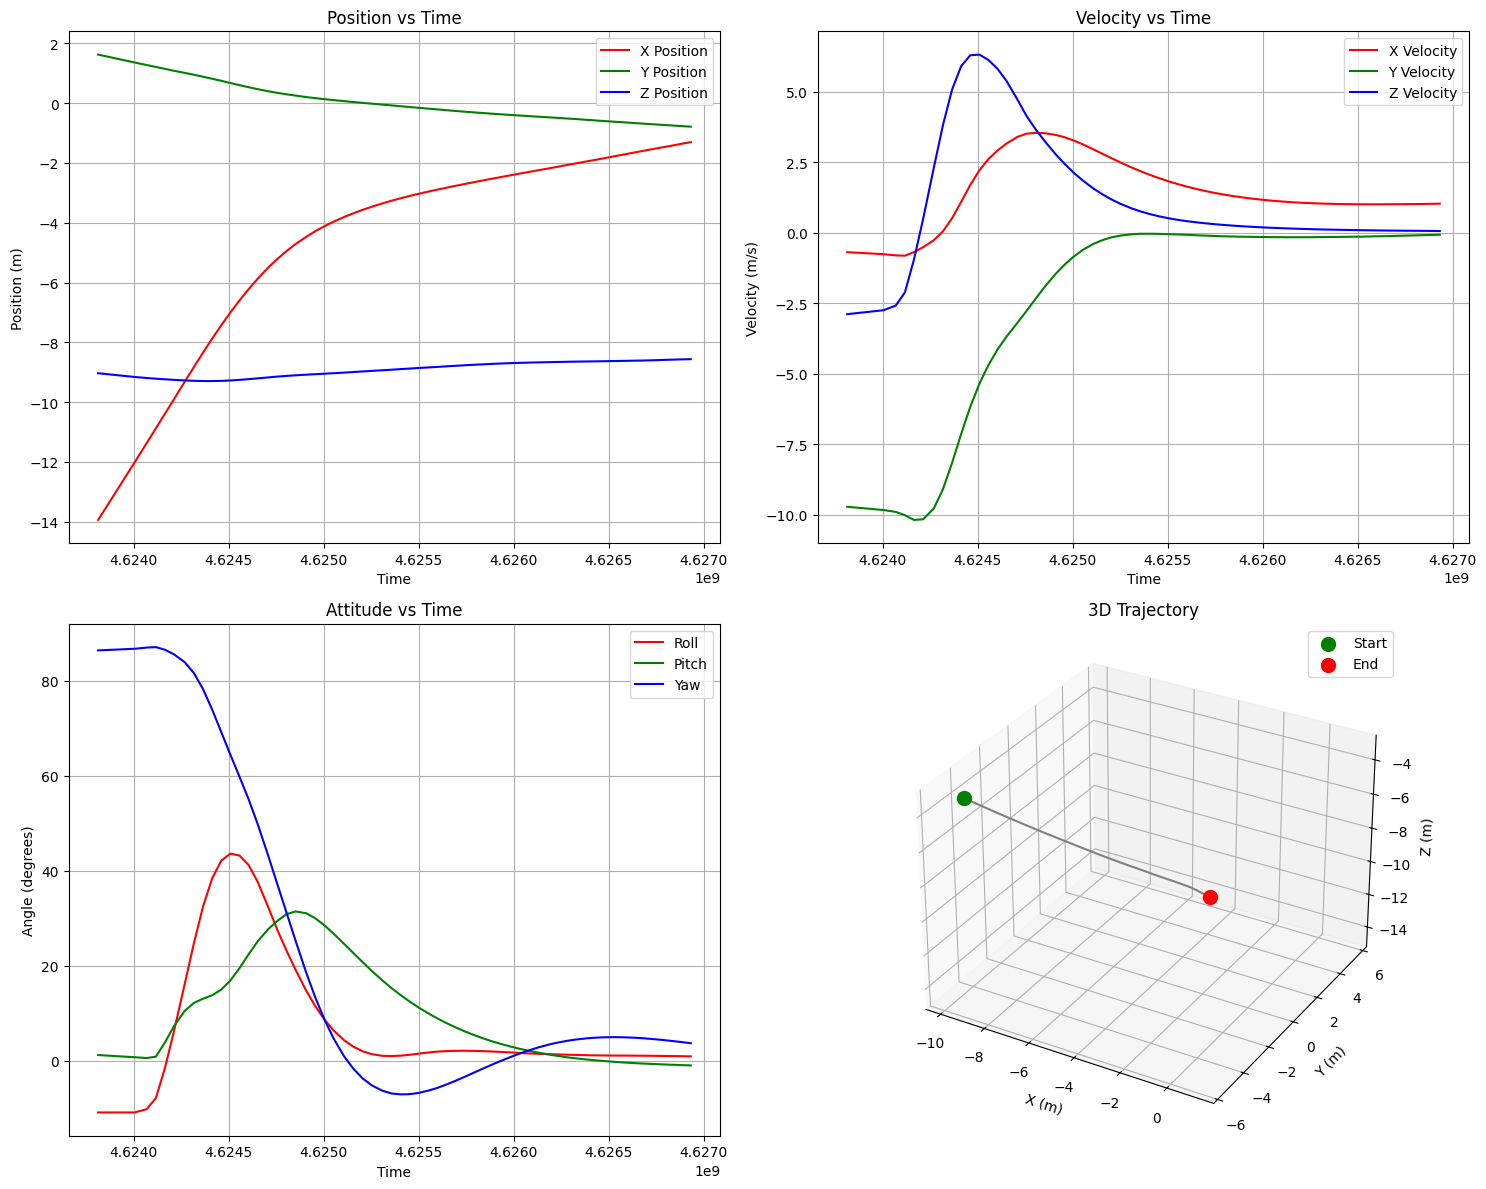

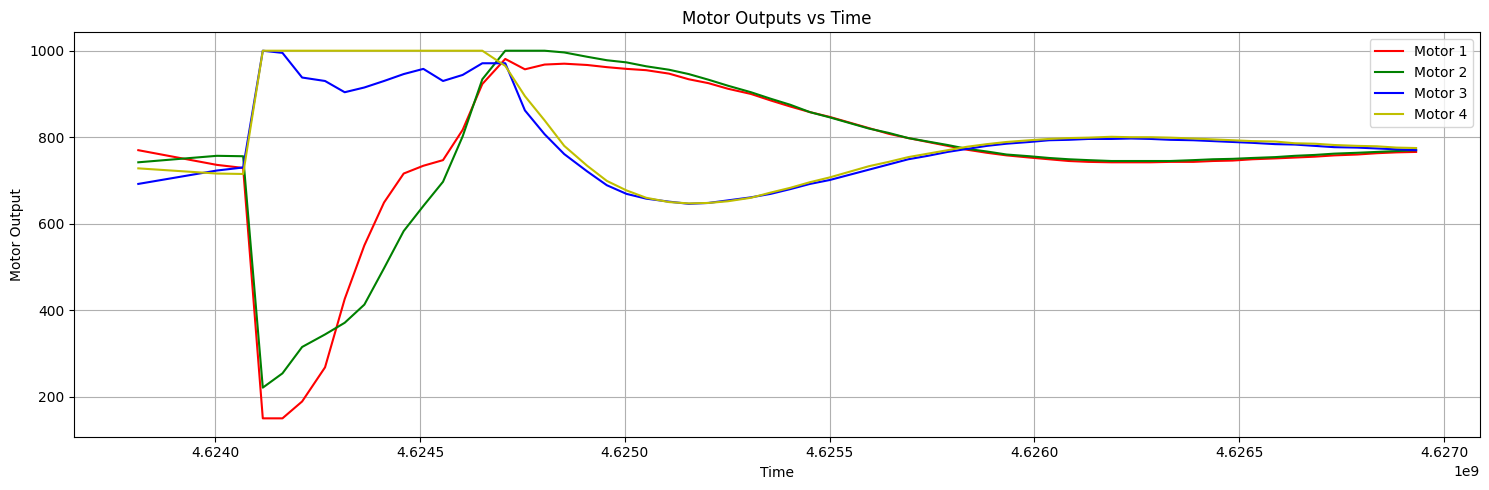

In [1]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('/home/eashan/workspace/DreamingFalconROS/flight_logs/flight_data_20250420-131528.csv')

# Access the data
positions = df[['x', 'y', 'z']].values
velocities = df[['vx', 'vy', 'vz']].values
attitudes = df[['roll', 'pitch', 'yaw']].values

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Check if there's a timestamp column, otherwise create one
if 'timestamp' in df.columns:
    time_data = df['timestamp'].values
else:
    time_data = np.arange(len(df))

# Create 4 subplots in a 2x2 grid
fig = plt.figure(figsize=(15, 12))

# 1. Position plot
ax1 = fig.add_subplot(221)
ax1.plot(time_data, df['x'], 'r-', label='X Position')
ax1.plot(time_data, df['y'], 'g-', label='Y Position')
ax1.plot(time_data, df['z'], 'b-', label='Z Position')
ax1.set_title('Position vs Time')
ax1.set_xlabel('Time')
ax1.set_ylabel('Position (m)')
ax1.grid(True)
ax1.legend()

# 2. Velocity plot
ax2 = fig.add_subplot(222)
ax2.plot(time_data, df['vx'], 'r-', label='X Velocity')
ax2.plot(time_data, df['vy'], 'g-', label='Y Velocity')
ax2.plot(time_data, df['vz'], 'b-', label='Z Velocity')
ax2.set_title('Velocity vs Time')
ax2.set_xlabel('Time')
ax2.set_ylabel('Velocity (m/s)')
ax2.grid(True)
ax2.legend()

# 3. Attitude plot
ax3 = fig.add_subplot(223)
ax3.plot(time_data, np.degrees(df['roll']), 'r-', label='Roll')
ax3.plot(time_data, np.degrees(df['pitch']), 'g-', label='Pitch')
ax3.plot(time_data, np.degrees(df['yaw']), 'b-', label='Yaw')
ax3.set_title('Attitude vs Time')
ax3.set_xlabel('Time')
ax3.set_ylabel('Angle (degrees)')
ax3.grid(True)
ax3.legend()

# 4. 3D trajectory plot
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot3D(df['x'], df['y'], df['z'], 'gray')
ax4.scatter(df['x'].iloc[0], df['y'].iloc[0], df['z'].iloc[0], 
           color='green', marker='o', s=100, label='Start')
ax4.scatter(df['x'].iloc[-1], df['y'].iloc[-1], df['z'].iloc[-1], 
           color='red', marker='o', s=100, label='End')
ax4.set_title('3D Trajectory')
ax4.set_xlabel('X (m)')
ax4.set_ylabel('Y (m)')
ax4.set_zlabel('Z (m)')
ax4.legend()

# Make the axes equal for the 3D plot to avoid distortion
max_range = max(
    np.ptp(df['x']), 
    np.ptp(df['y']), 
    np.ptp(df['z'])
)
mid_x = np.mean(df['x'])
mid_y = np.mean(df['y'])
mid_z = np.mean(df['z'])
ax4.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
ax4.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
ax4.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

plt.tight_layout()
plt.show()

# Additionally, let's create plots for the motor outputs
plt.figure(figsize=(15, 5))
plt.plot(time_data, df['motor1'], 'r-', label='Motor 1')
plt.plot(time_data, df['motor2'], 'g-', label='Motor 2')
plt.plot(time_data, df['motor3'], 'b-', label='Motor 3')
plt.plot(time_data, df['motor4'], 'y-', label='Motor 4')
plt.title('Motor Outputs vs Time')
plt.xlabel('Time')
plt.ylabel('Motor Output')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Length of df: 61
dts shape: torch.Size([1, 61])
acts shape: torch.Size([1, 61, 4])
states shape: torch.Size([1, 61, 12])


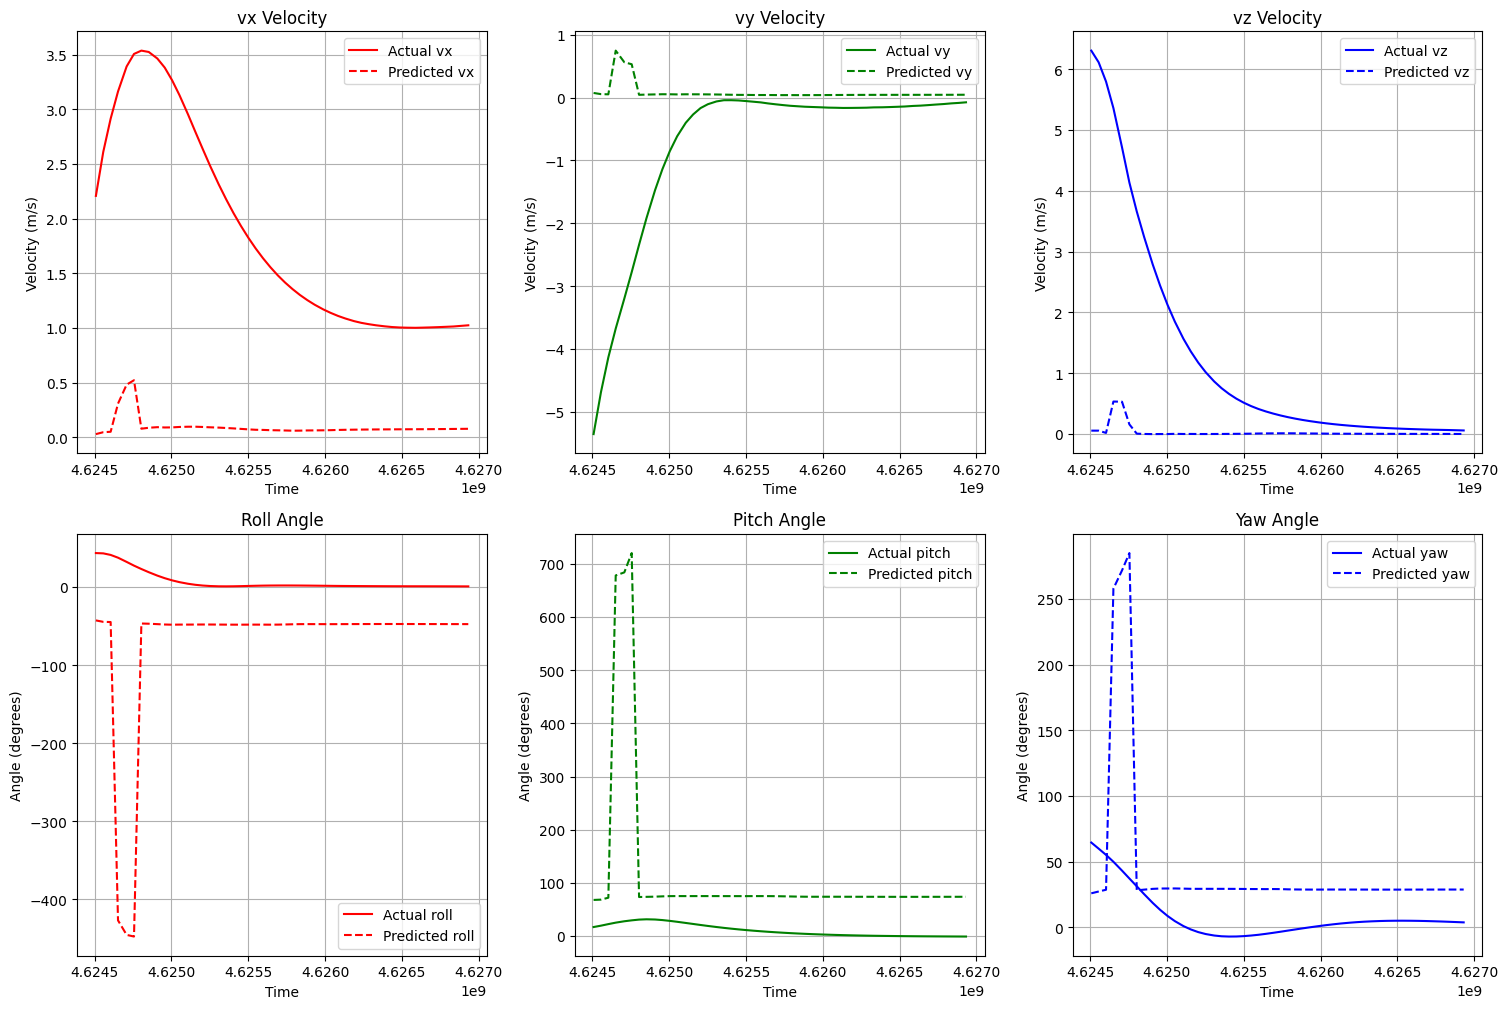

In [3]:
import torch
from models import WorldModelRNN
from utils import AttrDict
import yaml
import numpy as np
import matplotlib.pyplot as plt

# Normalization factors
position_norm_factor = 25.0
velocity_norm_factor = 10.0

# Function to normalize a state vector (assumes state is a 12-dimensional vector).
def normalize_state(state):
    normalized = state.copy()
    # Normalize positions (x, y, z) - indices 0, 1, 2
    normalized[0:3] = normalized[0:3] / position_norm_factor
    # Normalize velocities (vx, vy, vz) - indices 3, 4, 5
    normalized[3:6] = normalized[3:6] / velocity_norm_factor
    return normalized

# Function to denormalize a state vector.
def denormalize_state(state):
    denormalized = state.copy()
    # Denormalize velocities
    denormalized[3:6] = denormalized[0:3] * velocity_norm_factor
    return denormalized

# Load configuration and initialize the WorldModel
with open("/home/eashan/workspace/DreamingFalconROS/config.yaml", 'r') as file:
    config_dict = yaml.safe_load(file)

config = AttrDict.from_dict(config_dict)
device = torch.device(config.device)
world_model = WorldModelRNN(config, device).to(device)
checkpoint = torch.load("/home/eashan/workspace/DreamingFalconROS/models/run_0/model.pt", map_location=device)
world_model.load_state_dict(checkpoint["state_dict"])
world_model.eval()  # Set the model to evaluation mode

# --- Prepare input data for the rollout ---

print(f"Length of df: {len(df)}")
with torch.no_grad():
    # Extract time differences, actions, and the 12-dimensional states.
    dts = df['dt'].values.astype(np.float32)
    acts = df[['motor1', 'motor2', 'motor3', 'motor4']].values.astype(np.float32)
    states = df[['x', 'y', 'z', 'vx', 'vy', 'vz',
                              'roll', 'pitch', 'yaw',
                              'roll_rate', 'pitch_rate', 'yaw_rate']].values.astype(np.float32)
    
    # Normalize the states along axis=1 (each row/state)
    normalized_states = np.apply_along_axis(normalize_state, 1, states)
    
    # Convert numpy arrays to tensors
    dts_tensor = torch.from_numpy(dts).to(device=device).unsqueeze(0)
    acts_tensor = torch.from_numpy(acts).to(device=device).unsqueeze(0)
    states_tensor = torch.from_numpy(normalized_states).to(device=device).unsqueeze(0)

    print(f"dts shape: {dts_tensor.shape}")
    print(f"acts shape: {acts_tensor.shape}")
    print(f"states shape: {states_tensor.shape}")
    
    # Run the rollout with the normalized state inputs.
    rollout_pred = world_model.rollout(dts_tensor, states_tensor, acts_tensor, num_rollout=51)
    
    # Remove the batch dimension and denormalize the predicted states for visualization.
    predicted_states = rollout_pred.squeeze(0).cpu().numpy()  # shape: (seq_len, 12)
    predicted_states = denormalize_state(predicted_states)

# --- Prepare actual states for plotting ---
# Here, actual_states are extracted as 12-dimensional values from the DataFrame.
actual_states = df[['x', 'y', 'z', 'vx', 'vy', 'vz',
                    'roll', 'pitch', 'yaw',
                    'roll_rate', 'pitch_rate', 'yaw_rate']].values  # shape: (history_len, 12)

# Use the DataFrame's timestamp column for the x-axis.
time_data = df['timestamp'].values  # Ensure this aligns with the rollout predictions

# --- Plotting ---
plt.figure(figsize=(20, 15))

# Plot velocities (vx, vy, vz) -- indices 3, 4, 5
for i, (axis, color) in enumerate(zip(['vx', 'vy', 'vz'], ['r', 'g', 'b'])):
    plt.subplot(3, 4, i+5)
    plt.plot(time_data[11:], actual_states[11:, i+3], f'{color}-', label=f'Actual {axis}')
    plt.plot(time_data[11:], predicted_states[:, i], f'{color}--', label=f'Predicted {axis}')
    plt.title(f'{axis} Velocity')
    plt.xlabel('Time')
    plt.ylabel('Velocity (m/s)')
    plt.grid(True)
    plt.legend()

# Plot attitudes (roll, pitch, yaw in degrees) -- indices 6, 7, 8
for i, (axis, color) in enumerate(zip(['roll', 'pitch', 'yaw'], ['r', 'g', 'b'])):
    plt.subplot(3, 4, i+9)
    plt.plot(time_data[11:], np.degrees(actual_states[11:, i+6]), f'{color}-', label=f'Actual {axis}')
    plt.plot(time_data[11:], np.degrees(predicted_states[:, i+3]), f'{color}--', label=f'Predicted {axis}')
    plt.title(f'{axis.capitalize()} Angle')
    plt.xlabel('Time')
    plt.ylabel('Angle (degrees)')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()